# Week 6 - Vector Space Word Embeddings

Wanitchaya Poonpatanapricha

In [1]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using at least two different specification of `word2vec`, and visualize them each with two separate visualization layout specifications (e.g., TSNE, PCA). Then interrogate critical word vectors within your corpus in terms of the most similar words, analogies, and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the semantic organization of words in your corpora? Which estimation and visualization specification generate the most insight and appear the most robustly supported and why? 

<span style="color:red">***Stretch***: Explore different vector calculations beyond addition and subtraction, such as multiplication, division or some other function. What does this exploration reveal about the semantic structure of your corpus?

In [5]:
import pandas as pd

In [364]:
def combine_emoji(text, lst):
    lst = lst[1:-1].split(', ')
    for emoji in lst:
        if emoji != '':
            text += " " + "emoji_" + "_".join(emoji[1:-1].split())
    return text

In [365]:
tsuki = pd.read_csv("tsuki_polite5.csv")
tsuki['full_text'] = tsuki.apply(lambda x: combine_emoji(x.text, x.emoji), axis=1)
tsuki

,Unnamed: 0,language,emoji,text,is_emoji,num_emoji,polite_5,full_text
0,0,en,[],i still have tons of moonpies and halloween fo...,False,0,2,i still have tons of moonpies and halloween fo...
1,1,en,[],i go to the forest to see how much i have beca...,False,0,2,i go to the forest to see how much i have beca...
2,2,cn,[],hahahaha,False,0,4,hahahaha
3,3,es,[],hahahaha,False,0,4,hahahaha
4,4,pt,[],hahahaha,False,0,4,hahahaha
...,...,...,...,...,...,...,...,...
4482,4859,en,[],Tsuki fishing up the mayor's dead grandaughter...,False,0,0,Tsuki fishing up the mayor's dead grandaughter...
4483,4860,ph,[],-tsuki’s festive scarf/holiday scarf,False,0,2,-tsuki’s festive scarf/holiday scarf
4484,4861,ph,['HEAVY BLACK HEART'],-snowball fight w friends -snowman making duri...,True,1,1,-snowball fight w friends -snowman making duri...
4485,4862,en,['mocahype'],<user_mention> it worked! Thanks again!,True,1,4,<user_mention> it worked! Thanks again! emoji...


In [366]:
#Apply our functions, notice each row is a list of lists now
tsuki['tokenized_sents'] = tsuki['full_text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
tsuki['normalized_sents'] = tsuki['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])

# Word2Vec

In [368]:
tsukiW2V = gensim.models.word2vec.Word2Vec(tsuki['normalized_sents'].sum())

In [728]:
len(tsukiW2V.wv.index2word)

883

The total number of unique words is my corpus is **extremely small**! So I don't think I can expect much from this embedding model :( However, it is still fun to try it out.

## similar words

In [369]:
tsukiW2V.most_similar('tsuki')

[('need', 0.9995445013046265),
 ('game', 0.9994903206825256),
 ('like', 0.9994398951530457),
 ('buy', 0.9994387030601501),
 ('gift', 0.9994063973426819),
 ('m', 0.9993833899497986),
 ('time', 0.9993781447410583),
 ('u', 0.9993780851364136),
 ('nt', 0.9993592500686646),
 ('forest', 0.9993271231651306)]

If we had bigger corpus, we probably see `tsuki` closer to other characters' names (`tsuki` is the name of the main character). However, we still kind of see that it is closer to `game`.

In [370]:
tsukiW2V.most_similar('emoji_yaycarrots')

[('buy', 0.9643827080726624),
 ('option', 0.9641475081443787),
 ('know', 0.9641439914703369),
 ('long', 0.9637794494628906),
 ('think', 0.9637621641159058),
 ('items', 0.9636520743370056),
 ('luck', 0.9634677767753601),
 ('hours', 0.9633471965789795),
 ('times', 0.9632368087768555),
 ('day', 0.963173508644104)]

This is actually pretty good! `carrots` is the currency in this game. So seeing that the most similar word is `buy` is encouraging.

In [371]:
tsukiW2V.most_similar('emoji_thinking_face')

[('confused', 0.18283337354660034),
 ('nvm', 0.1689523160457611),
 ('emoji_pepeexcited', 0.1574982851743698),
 ('dad', 0.1427084058523178),
 ('wonder', 0.1411529779434204),
 ('emoji_smiling_face_with_open_mouth_and_tightly', 0.13933250308036804),
 ('awesome', 0.1279294192790985),
 ('woah', 0.12636451423168182),
 ('dog', 0.12431782484054565),
 ('slowly', 0.1222057044506073)]

The result for `emoji_thinking_face` is pretty good too. You can see that many close terms are emotion related (`confused`, `wonder`, `woah`). Also, it captures some face and emotion emoji! (`emoji_pepeexcited`, `emoji_smiling_face_with_open_mouth_and_tightly`)

In [372]:
tsukiW2V.doesnt_match(['emoji_yaycarrot', 'emoji_mocahype', 'emoji_thinking_face',
                      'emoji_sparkling_heart', 'emoji_smiling_face_with_smiling_eyes'])

'emoji_thinking_face'

I guess it can kind of capture that `emoji_thinking_face` is related to more serious content than the rest of emoji.

In [374]:
tsukiW2V.doesnt_match(['tsuki', 'chi', 'moca', 'pipi', 'yori', 'bobo', 'dawn', 'mori', 'momo'])

'mori'

Above are the name of several characters. `mori` is the very old turtle. So I guess we can see she is kind of different from the rest.

## analogy

In [375]:
tsukiW2V.most_similar(positive=['mushroom','ed'], negative=['tsuki'])

[('left', 0.9942869544029236),
 ('forest', 0.9939718246459961),
 ('going', 0.9939194917678833),
 ('red', 0.9938446879386902),
 ('gift', 0.9938445091247559),
 ('yukiyama', 0.9938281178474426),
 ('said', 0.9938153028488159),
 ('able', 0.9937303066253662),
 ('buy', 0.9937291145324707),
 ('present', 0.9937232732772827)]

Above, Tsuki lives in Mushroom Village while Ed lives in the Forest. We can see that `mushroom` + `ed` - `tsuki` = `forest` in the second closest terms. Given the size of the corpus, this is pretty good.

In [378]:
tsukiW2V.most_similar(positive=['pipi','old'], negative=['young'])

[('players', 0.8776834011077881),
 ('reached', 0.8763934969902039),
 ('saw', 0.8714412450790405),
 ('channel', 0.8714146614074707),
 ('graveyard', 0.8711012601852417),
 ('tsukiadventure', 0.8707184791564941),
 ('club', 0.8702371120452881),
 ('asks', 0.8701411485671997),
 ('cave', 0.8699749708175659),
 ('floor', 0.8697935938835144)]

I expect `pipi` (the youngest character) - `young` + `old` to be some older character, especially `yori` which is Pipi's dad. However, this doesn't work as well as the location analogy above. Probably because the size of the corpus. However, the 5th most similar term is `graveyard` which has Pipi's late mother. So maybe it does capture a bit of this analogy?

In [379]:
tsukiW2V.most_similar(positive=['ken', 'good'], negative=['bad'])

[('present', 0.9922012686729431),
 ('kubo', 0.9917168617248535),
 ('got', 0.9915693998336792),
 ('mushroom', 0.9914295077323914),
 ('work', 0.9913449883460999),
 ('moca', 0.9913027882575989),
 ('gifts', 0.9912925958633423),
 ('event', 0.991289496421814),
 ('game', 0.9911245107650757),
 ('gift', 0.9911230206489563)]

`ken` is a bit of a mafia, while `kubo` is a monk. No wonder `ken` + `good` - `bad` = `kubo`!

In [380]:
tsukiW2V.most_similar(positive=['emoji_thinking_face', 'happy'], negative=['sad'])

[('confused', 0.2276395708322525),
 ('nvm', 0.16106319427490234),
 ('dad', 0.1583559364080429),
 ('emoji_smiling_face_with_open_mouth_and_tightly', 0.15323537588119507),
 ('woah', 0.1502571702003479),
 ('awesome', 0.1472925841808319),
 ('wondering', 0.1448744833469391),
 ('wonder', 0.14483961462974548),
 ('dog', 0.13926441967487335),
 ('cases', 0.1366928070783615)]

I am surprised that `emoji_thinking_face` + `happy` - `sad` = `emoji_smiling_face_with_open_mouth_and_tightly` as the 4th most similar! Not bad at all giving my corpus size :)

## Plot

In [381]:
numWords = 50
targetWords = tsukiW2V.wv.index2word[:numWords]

In [382]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(tsukiW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)

In [383]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

### TSNE

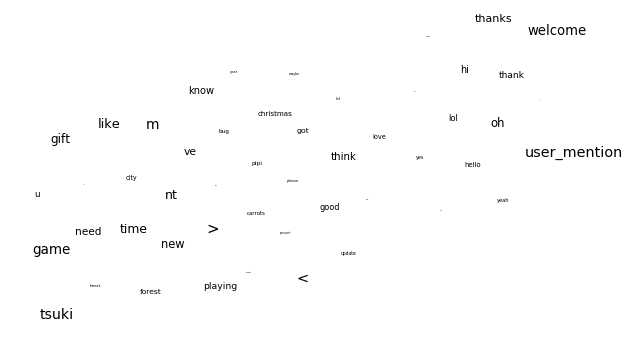

In [384]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  15 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

We can see more general conservational terms in one area (`welcome`, `thanks`, `hi`, `lol`) and more terms specific about Tsuki game cluster in the otehr area (`tsuki`, `game`, `forest`, `gift`).

### PCA

In [385]:
pc_df = pd.DataFrame(reducedPCA_data)
pc_df['pc1'] = pc_df[0]
pc_df['pc2'] = pc_df[1]

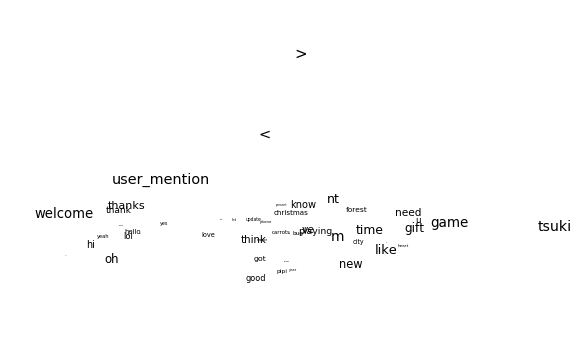

In [386]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(pc_df['pc1'], pc_df['pc2'], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (pc_df['pc1'].loc[i],pc_df['pc2'].loc[i]), size =  15 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

PCA plot has the general clustering as TSNE plot. However, the dimension is way flatter than the one in TSNE. This is probably because for PCA plot, we only take the 1st and 2nd PC while for TSNE, we reduced many PCs to 2 dimensions.

# Doc2Vec

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using `doc2vec`, and explore the relationship between different documents and the word vectors you analyzed in the last exercise. Consider the most similar words to critical documents, analogies (doc _x_ + word _y_), and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the documentary organization of your semantic space?

In [484]:
keywords = ['tsuki', 'carrot', 'haha', 'sad', 'lol', 'cute']

In [485]:
tsuki['tokenized_words'] = tsuki['full_text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
tsuki['normalized_words'] = tsuki['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [486]:
taggedDocs = []
for index, row in tsuki.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    #docKeywords.append(row['copyrightYear'])
    docKeywords += [row['Unnamed: 0']] #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
tsuki['TaggedAbstracts'] = taggedDocs

In [530]:
tsukiD2V = gensim.models.doc2vec.Doc2Vec(tsuki['TaggedAbstracts'], vector_size = 300) #Limiting to 100 dimensions

### Doc -> Word  & Analogy
#### Example 1

In [488]:
tsuki['full_text'].loc[1000]

'the moment tsuki submitted his resignation letter, he fell in the staircase while a carrot ||stabs|| through his body and||died|| '

In [489]:
tsukiD2V.most_similar( [ tsukiD2V.docvecs[1000] ], topn=5) 

[('rabbitstare:614113473474854913', 0.047529011964797974),
 ('oohh', 0.043304696679115295),
 ('os', 0.02351311221718788),
 ('yori_loves_chi:652933152024821821', 0.008200371637940407),
 ('emoji_wth', 0.0013052690774202347)]

I quite agree with `emoji_wth` and `rabbitstare` for the text above! Accurate reaction!

In [526]:
tsukiD2V.docvecs.most_similar(positive = [tsukiD2V.docvecs[1000]], 
                              negative = [tsukiD2V['sad']], topn = 5)

[(2246, 0.9368118047714233),
 (4031, 0.9349709749221802),
 (1139, 0.8992236852645874),
 (2043, 0.8867027759552002),
 (2757, 0.8752703666687012)]

In [527]:
tsuki['full_text'].loc[2246]

'What are you doing tsuki  emoji_FACE_WITH_TEARS_OF_JOY'

Subtracting `sad` from the original document, we get this new document which is clearly more positive.

#### Example 2

In [490]:
tsuki['full_text'].loc[1500]

"Hello, I'm Sheela and I love tsuki adventure!!! Been lurking around for awhile but only got to introduce myself now! Please be my friend.  emoji_hug"

In [491]:
tsukiD2V.most_similar( [ tsukiD2V.docvecs[1500] ], topn=5) 

[('a:6454_nekoatsume_yay:639823333365645312', 0.0675956979393959),
 ('welcomee', 0.03888467326760292),
 ('oohh', 0.03582020848989487),
 ('np', -0.008245855569839478),
 ('bruh', -0.01128658652305603)]

This is a self-introduction kind of document, so `welcome` and something positive like `nekoatsume_yay` make sense.

In [531]:
tsukiD2V.docvecs.most_similar(positive = [tsukiD2V.docvecs[1500]], 
                              negative = [tsukiD2V['happy']], topn = 5)

[(1973, 0.9664041996002197),
 (2168, 0.9162482023239136),
 (869, 0.9027706384658813),
 (1660, 0.9007610082626343),
 (1650, 0.8935094475746155)]

In [532]:
tsuki['full_text'].loc[1973]

'Present stuck on screen '

Taking `happy` out of the original document, we get this document that is.... probably sad :(

### Heatmaps

In [492]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = tsukiD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, tsukiD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

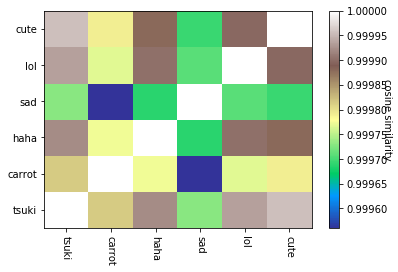

In [493]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

By keyword, there doesn't seem to be any apparent pattern except that `sad` is quite different from the rest. This makes sense because the rest of the words are more positive than negative. The word `carrot` is also moderately different. This is probably because it is uniquely used when talking about transaction.

In [494]:
targetDocs = tsuki['Unnamed: 0'][1000:1020]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = tsukiD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, tsukiD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

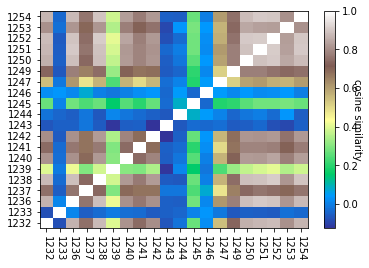

In [495]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Seems like some documents are pretty closed while some are very different.

This is the quite different one:

In [496]:
tsuki['full_text'].iloc[1243]

'tsuki playing chapteh with pipi '

This is the quite similar one:

In [497]:
tsuki['full_text'].iloc[1254]

'lol wei wei no nsfw '

In [498]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = tsukiD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, tsukiD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

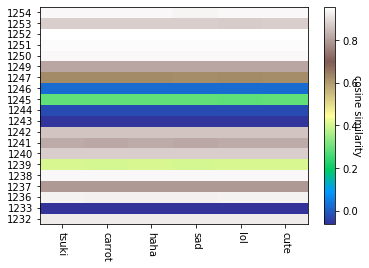

In [499]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Interestingly, each document doesn't really differ between keywords. This is likely because each document is **extremely short**! Again, this corpus is not really ideal for word embedding at all.

# Projection

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project, then generate meaningful semantic dimensions based on your theoretical understanding of the semantic space (i.e., by subtracting semantically opposite word vectors) and project another set of word vectors onto those dimensions. Interpret the meaning of these projections for your analysis. Which of the dimensions you analyze explain the most variation in the projection of your words and why? 

<span style="color:red">***Stretch***: Average together multiple antonym pairs to create robust semantic dimensions. How do word projections on these robust dimensions differ from single-pair dimensions?

Let's set the target words to be several characters in the game.

In [586]:
#words to create dimensions
tsukiTargetWords = ['happy','sad','young', 'old','big','small',
                   'city', 'village','fast','slow','forest']
#words we will be mapping
tsukiTargetWords += ['tsuki', 'chi', 'yori', 'pipi', 'moca', 'momo', 'mori','kubo', 'ken',
                   'sheriff', 'clive', 'bobo', 'kubo', 'ed']

wordsSubMatrix = []
for word in tsukiTargetWords:
    wordsSubMatrix.append(tsukiW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [587]:
pcaWordstsuki = sklearn.decomposition.PCA(n_components = 20).fit(wordsSubMatrix)
reducedPCA_datatsuki = pcaWordstsuki.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordstsuki = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_datatsuki)

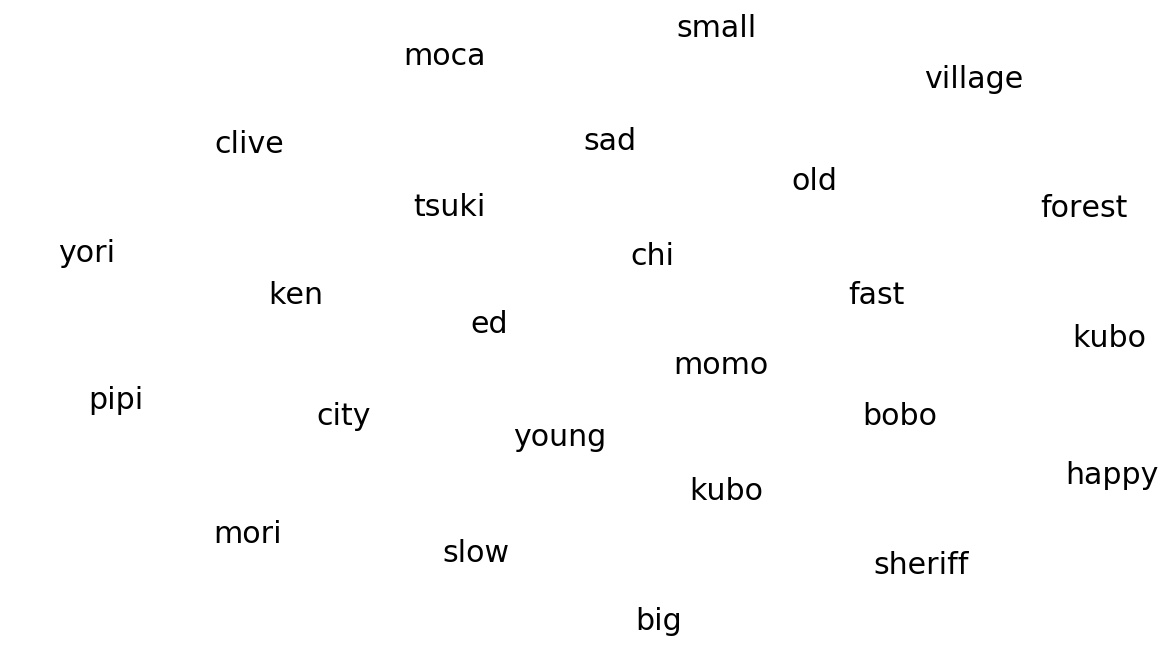

In [588]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordstsuki[:, 0], tsneWordstsuki[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tsukiTargetWords):
    ax.annotate(word, (tsneWordstsuki[:, 0][i],tsneWordstsuki[:, 1][i]), size =  30)
plt.xticks(())
plt.yticks(())
plt.show()

In [589]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

### Multiple Antonym Pairs

Let's calculate three dimensions: age, location, and trait. Note that only age is the average of multiple antonym pairs.

In [730]:
Age = dimension(tsukiW2V, ['young','small','fast'], ['old','big','slow'])
Location = dimension(tsukiW2V, ['city'], ['village'])
Trait = dimension(tsukiW2V, ['happy'], ['sad'])

In [731]:
def makeDF(model, word_list):
    a = []
    l = []
    t = []
    for word in word_list:
        a.append(sklearn.metrics.pairwise.cosine_similarity(tsukiW2V[word].reshape(1,-1), Age.reshape(1,-1))[0][0])
        l.append(sklearn.metrics.pairwise.cosine_similarity(tsukiW2V[word].reshape(1,-1), Location.reshape(1,-1))[0][0])
        t.append(sklearn.metrics.pairwise.cosine_similarity(tsukiW2V[word].reshape(1,-1), Trait.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'age': a, 'location': l, 'trait': t}, index = word_list)
    return df

In [732]:
df = makeDF(tsukiW2V, 
            ['tsuki', 'chi', 'yori', 'pipi', 'moca', 'momo', 'mori',
             'kubo', 'ken','sheriff', 'clive', 'bobo', 'kubo','ed']) 

In [733]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.8, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

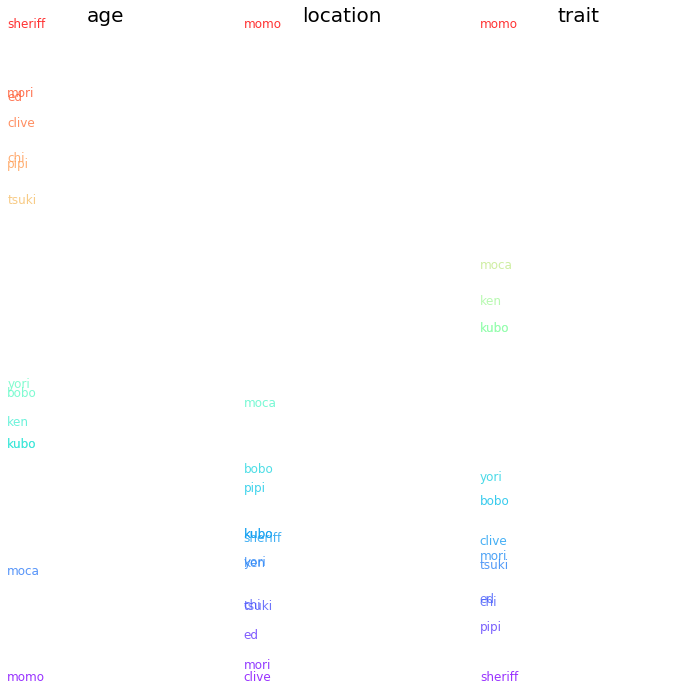

In [734]:
fig = plt.figure(figsize = (12,12))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, df, 'age')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, df, 'location')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, df, 'trait')
plt.show()

The result is not that bad! `mori` is the oldest character. `clive` lives in the city. But well, it will be a lot better if we had bigger corpus. So this is already impressive!

### Single Antonym Pair

Let's try separate age into 3 dimensions each with only one antonym pair.

In [735]:
Age = dimension(tsukiW2V, ['young'], ['old'])
Size = dimension(tsukiW2V, ['small'], ['big'])
Movement = dimension(tsukiW2V, ['fast'], ['slow'])

In [736]:
def makeDF(model, word_list):
    a = []
    l = []
    t = []
    for word in word_list:
        a.append(sklearn.metrics.pairwise.cosine_similarity(tsukiW2V[word].reshape(1,-1), Age.reshape(1,-1))[0][0])
        l.append(sklearn.metrics.pairwise.cosine_similarity(tsukiW2V[word].reshape(1,-1), Size.reshape(1,-1))[0][0])
        t.append(sklearn.metrics.pairwise.cosine_similarity(tsukiW2V[word].reshape(1,-1), Movement.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'age': a, 'size': l, 'movement': t}, index = word_list)
    return df

In [738]:
df = makeDF(tsukiW2V, 
            ['tsuki', 'chi', 'yori', 'pipi', 'moca', 'momo', 'mori',
             'kubo', 'ken','sheriff', 'clive', 'bobo', 'kubo','ed']) 

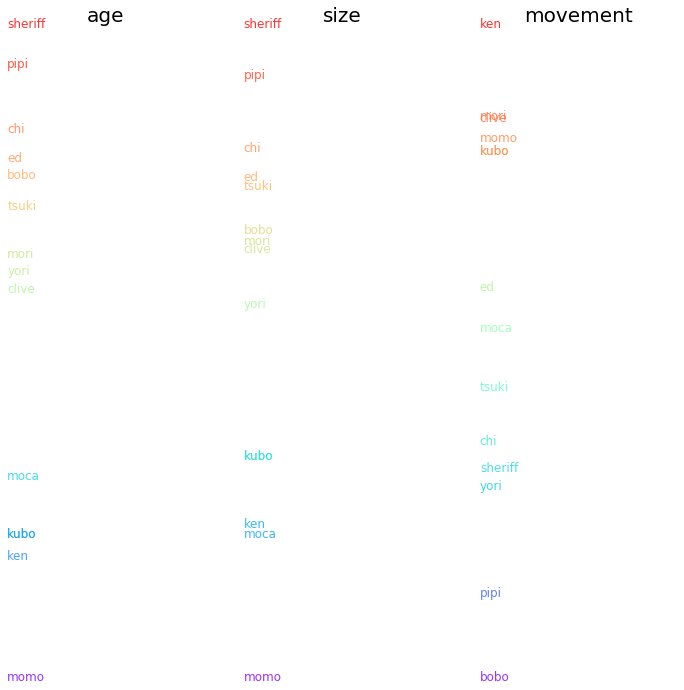

In [739]:
fig = plt.figure(figsize = (12,12))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, df, 'age')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, df, 'size')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, df, 'movement')
plt.show()

This doesn't seem as good as the multiple antonym pairs anymore :(

# The Score Function

## <span style="color:red">*Exercise 4a*</span>

<span style="color:red">**Do only 4a or 4b.** Construct cells immediately below this that calculate the scores for a small sample of documents from outside your corpus to identify which are *closest* to your corpus. Then calculate the scores for a few phrases or sentences to identify the ones most likely to have appeared in your corpus. Interrogate patterns associated with these document/phrase scores (e.g., which companies produced job ads most or least likely to find jobseekers in the resume corpus?) What do these patterns suggest about the boundaries of your corpus?

In [614]:
tsukiW2V = gensim.models.Word2Vec(tsuki['normalized_sents'].sum(), hs=1, negative=0)

In [617]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

Let's try using #metoo tweets to see how close the chat in this game community is to tweets about #metoo.

In [625]:
metoo = pd.read_csv("metoo_emoji.csv")
metoo_small = metoo.iloc[:100,:]
metoo_small['tokenized_sents'] = metoo_small['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
metoo_small['normalized_sents'] = metoo_small['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])

/Users/wanitchaya.poon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/wanitchaya.poon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [626]:
metoo_small['likelihood'] = metoo_small['normalized_sents'].apply(lambda x: adprob(x, tsukiW2V))

/Users/wanitchaya.poon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Top likelihood tweets:

In [629]:
for ad in metoo_small.sort_values(by = 'likelihood', ascending = False)['text'][:5]:
    print (ad + '\n\n')

#MeToo [by Society6 Artist @witchoria] https://t.co/oDYGexXYR5 https://t.co/p1U8qD4Hv6


The #MeToo campaign is empowering and simultaneously heartbreaking ..


When I was 7 by babysitter #MeToo https://t.co/6hKwtP2HC3


Especially rife in the 1970s #metoo https://t.co/79sW8zHCsj


You are not alone. #MeToo




Bottom likelihood tweets:

In [633]:
for ad in metoo_small.sort_values(by = 'likelihood')['text'][:5]:
    print (ad + '\n\n')

If you don't think every freaking woman on this earth has been harassed/cat-called at least once in their life, you're wrong #Metoo


I wasn't going to tweet #metoo because we've been tweeting, crying, hurting 'me too' for a long long time now.


#MeToo is cool if it offers peace and a sense of unity but let's not work under the false pretence that our narratives will make men care


Interesting that the men who have a problem with #MeToo are the same ones who wanted to "protect women" with bathroom bills.


Kinda sad that it takes a hashtag for people to realize how big the issue is #metoo




Seems like the bottom 5 are tweets that are longer and more complex. While the top 5 likely are those that are very short and not that descriptive.

### By terms

We can see more common/popular characters (`tsuki`, `pipi`) have higher likelihood. On the other hand, rarer characters (`jun`, `clive`) aren't as likely.

In [640]:
adprob([["tsuki", "pipi"]], tsukiW2V)

-9.303255

In [639]:
adprob([["jun", "clive"]], tsukiW2V)

-14.928364

Terms that are more specific are less likely that terms that are more general too.

In [642]:
adprob([["man", "woman"]], tsukiW2V)

-7.0521927

In [643]:
adprob([["welcome", "hi"]], tsukiW2V)

-9.700157

In [644]:
adprob([["game", "play"]], tsukiW2V)

-10.114061

# Linguistic Change or Difference

## <span style="color:red">*Exercise 4b*</span>

<span style="color:red">**Do only 4a or 4b.** Construct cells immediately below this that align word embeddings over time or across domains/corpora. Interrogate the spaces that result and ask which words changed most and least over the entire period or between contexts/corpora. What does this reveal about the social game underlying your space? 

In [645]:
import copy

In [650]:
def year_month(timestamp):
    return timestamp[:7]
tsuki = pd.read_csv("message_all.csv")
tsuki['time'] = tsuki['timestamp'].apply(year_month)
tsuki

,id,name,name_id,content,timestamp,channel,language,time
0,5.645833e+17,BREAD,7623,i still have tons of moonpies and halloween fo...,2020-02-15T16:53:46Z,chat,en,2020-02
1,5.645833e+17,BREAD,7623,i go to the forest to see how much i have beca...,2020-02-15T16:54:04Z,chat,en,2020-02
2,2.192137e+17,Hele,2896,hahahaha,2020-02-15T16:54:47Z,chat,cn,2020-02
3,2.192137e+17,Hele,2896,hahahaha,2020-02-15T16:54:47Z,chat,es,2020-02
4,2.192137e+17,Hele,2896,hahahaha,2020-02-15T16:54:47Z,chat,pt,2020-02
...,...,...,...,...,...,...,...,...
4859,5.720987e+17,Wei Wei,123,Tsuki fishing up the mayor's dead grandaughter...,2019-12-02T13:43:40Z,tsuki-suggestion,en,2019-12
4860,5.646385e+17,hurbyvore🌱,5569,-tsuki’s festive scarf/holiday scarf,2019-12-02T12:49:06Z,tsuki-suggestion,ph,2019-12
4861,5.646385e+17,hurbyvore🌱,5569,-snowball fight w friends \n-snowman making du...,2019-12-02T12:48:37Z,tsuki-suggestion,ph,2019-12
4862,6.166568e+17,gelizabee,5563,<@!392727704614731787> it worked! Thanks again...,2019-12-01T21:33:44Z,tsuki-suggestion,en,2019-12


In [651]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

In [653]:
tsuki['tokenized_sents'] = tsuki['content'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
tsuki['normalized_sents'] = tsuki['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [691]:
embeddings_raw = {}
subsetDF2 = tsuki[tsuki['time'] == '2019-12']
subsetDF3 = tsuki[tsuki['time'] == '2020-01']
subsetDF4 = tsuki[tsuki['time'] == '2020-02']
embeddings_raw['2019-12'] = gensim.models.word2vec.Word2Vec(subsetDF2['normalized_sents'].sum())
embeddings_raw['2020-01'] = gensim.models.word2vec.Word2Vec(subsetDF3['normalized_sents'].sum())
embeddings_raw['2020-02'] = gensim.models.word2vec.Word2Vec(subsetDF4['normalized_sents'].sum())

In [693]:
def compareModels(df, category, text_column_name='normalized_sents', sort = True, embeddings_raw={}):
    """If you are using time as your category sorting is important"""
    if len(embeddings_raw) == 0:
        embeddings_raw = rawModels(df, category, text_column_name, sort)
    cats = set(['2019-12', '2020-01', '2020-02'])
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [694]:
rawEmbeddings, comparedEmbeddings = compareModels(tsuki, 'time', embeddings_raw=embeddings_raw)

In [695]:
rawEmbeddings.keys()

dict_keys(['2019-12', '2020-01', '2020-02'])

So we have 3 different months to compare.

In [696]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pandas.DataFrame(dists, index = cats)

Lets look at a couple words:

tsuki


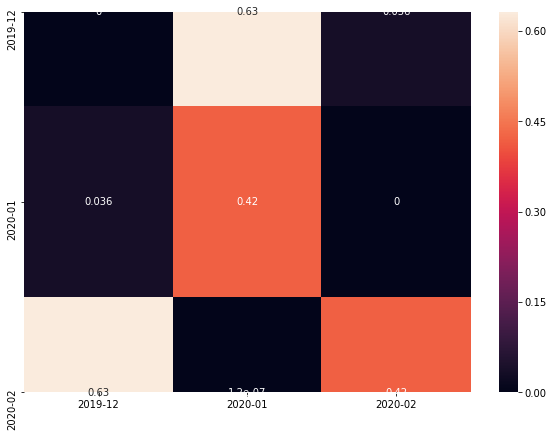

In [709]:
targetWord = 'tsuki'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = True) #set annot True for a lot more information
plt.show();

Interestingly, we don't see low divergence within the same month.... Could be because the corpus is so small that the alignment is not robust.

game


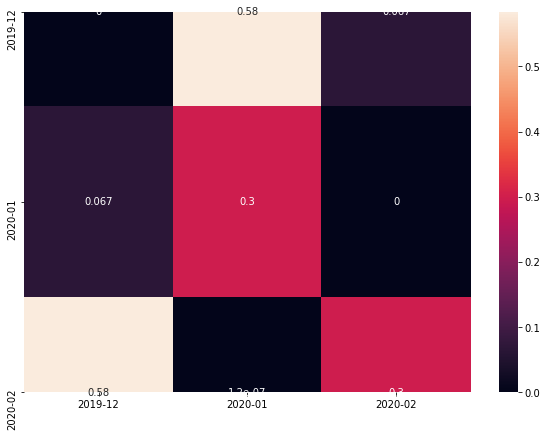

In [716]:
targetWord = 'game'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = True) #set annot True for a lot more information
plt.show()

In [717]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)
    

In [718]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 19 words to compare


Indeed, the corpus is very small! There are only 19 terms that can be compared across 3 months!

The most divergent words are:

In [723]:
wordDivergences[:5]

[('random', 1.2409997582435608),
 ('way', 1.2096902132034302),
 ('know', 1.2057476341724396),
 ('hug:589655063027253288', 1.1071052551269531),
 ('be', 1.0562925785779953)]

And the least:

In [724]:
wordDivergences[-5:]

[('<', 0.7305801808834076),
 ('>', 0.7227097451686859),
 ('tsuki', 0.6680406630039215),
 ('stay', 0.6627686619758606),
 ('game', 0.6509535908699036)]

random


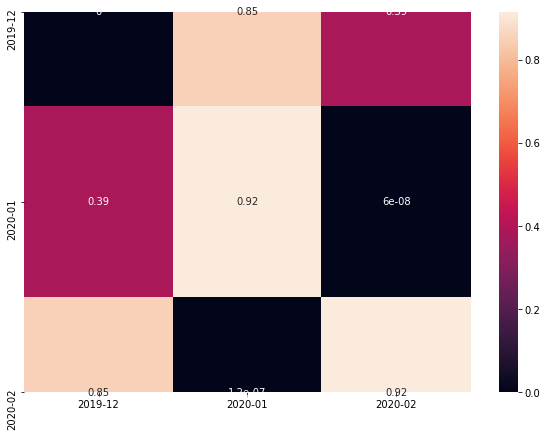

In [725]:
targetWord = wordDivergences[0][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = True) #set annot True for a lot more information
plt.show()

game


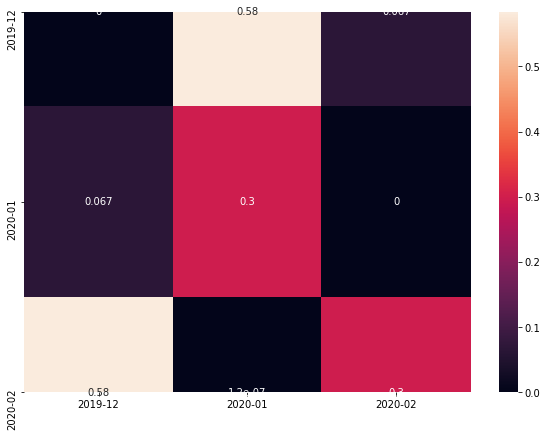

In [726]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = True) #set annot True for a lot more information

plt.show()

## Summary
* My corpus is very small, so it is **not suitable** for word embedding.
* This is especially disadvantageous to comparing word embeddings across time and document level embedding.
* However, surprisingly, the embedding still can capture some semantic relationship such as analogy between words!